# SSVI and local variance
*******
Reference:
J, Gatheral, A. Jacquier.
Arbitrage-free SVI volatility surfaces. 
Quantitative Finance, 14(1): 59-71, 2014.
https://www.tandfonline.com/doi/full/10.1080/14697688.2013.819986

In [1]:
from scipy.stats import norm
from numpy import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib.colors import cnames
import pandas as pd
from scipy.optimize import bisect

We consider the following SSVI parameterisation of the total implied variance surface:
$$
w(k,\theta_t)
= \frac{\theta_t}{2}\left\{1+\rho\varphi(\theta_t) k + \sqrt{\left(\varphi(\theta_t){k}+\rho\right)^2
+1-\rho^2 }\right\},
$$
with $\theta_t$ denotes the total at-the-money variance. Here $k:=\log(K/S_0)\in\mathbb{R}$ denotes the logmoneyness.

We then compute the (Dupire) local variance via the following formula:
$$
\sigma_{\mathrm{loc}}^2(k, T) := \frac{\partial_{t}w(k, \theta_{t})}{g(k, w(k, \theta_{t}))},
$$
for all $k\in\mathbb{R}$ and $t\geq 0$, where the function $g$ is fined in the paper.

Data could suggest some specific form for the increasing map $t\mapsto \theta_t$. For simplicity here, we take
$\theta_t \equiv \sigma^2 t$, for some $\sigma>0$.

The function~$\varphi$ is referred to as the backbone and needs to satisfy some assumptions to prevent arbitrage. We focus on two such specific examples below.

# Example 1

We consider the following function
$$
\varphi(\theta)\equiv\frac{1}{\gamma\theta}\left\{1-\frac{1-\mathrm{e}^{-\gamma\theta}}{\gamma\theta}\right\},
$$
where $\gamma>0$, $\rho \in (-1,1)$.
We further need to impose $\gamma \geq \frac{1}{4}\left(1+|\rho|\right)$ in order to prevent arbitrage.

In [3]:
def phi(theta, params):
    gamma, sigma, rho = params
    return 1./(gamma*theta)*(1.-(1.-np.exp(-gamma*theta))/(gamma*theta))

def SSVI(x, t, params):
    gamma, sigma, rho = params
    theta = sigma*sigma*t
    p = phi(theta, params)
    return 0.5*theta*(1.+rho*p*x+np.sqrt((p*x+rho)*(p*x+rho)+1.-rho*rho))

def SSVI1(x, t, params):
    ## First derivative with respect to x
    gamma, sigma, rho = params
    theta = sigma*sigma*t
    p = phi(theta, params)
    return 0.5*theta*p*(p*x+rho*np.sqrt(p*p*x*x+2.*p*rho*x+1.)+rho)/np.sqrt(p*p*x*x+2.*p*rho*x+1.)

def SSVI2(x, t, params):
    ## Second derivative with respect to x
    gamma, sigma, rho = params
    theta = sigma*sigma*t
    p = phi(theta, params)
    return 0.5*theta*p*p*(1.-rho*rho)/ ((p*p*x*x + 2.*p*rho*x + 1.)*np.sqrt(p*p*x*x+2.*p*rho*x+1.))
    
def SSVIt(x, t, params):
    ## First derivative with respect to t, by central difference
    gamma, sigma, rho = params
    eps = 0.0001
    return (SSVI(x,t+eps,params) - SSVI(x,t-eps,params))/(2.*eps)

def g(x, t, params):
    w = SSVI(x,t,params)
    w1 = SSVI1(x,t,params)
    w2 = SSVI2(x,t,params)
    return (1.-0.5*x*w1/w)*(1.-0.5*x*w1/w) - 0.25*w1*w1*(0.25 + 1./w) + 0.5*w2
    
def dminus(x, t, params):
    vsqrt = np.sqrt(SSVI(x,t,params))
    return -x/vsqrt - 0.5*vsqrt
    
def densitySSVI(x, t, params):
    dm = dminus(x,t,params)
    return g(x,t,params)*np.exp(-0.5*dm*dm)/np.sqrt(2.*np.pi*SSVI(x,t,params))

def SSVI_LocalVarg(x, t, params):
    ## Compute the equivalent SSVI local variance
    return SSVIt(x,t,params) / g(x,t,params)

### Numerical example of a SSVI local volatility surface

In [4]:
sigma, gamma, rho = 0.2, 0.8, -0.7
xx, TT = np.linspace(-1., 1., 50), np.linspace(0.001, 5., 50)

print("Consistency check to avoid static arbitrage: ", (gamma - 0.25*(1.+np.abs(rho))>0.))
params = gamma, sigma, rho

localVarianceSSVI = [[SSVI_LocalVarg(x, t, params) for x in xx] for t in TT]
impliedVarianceSSVI = [[SSVI(x, t, params) for x in xx] for t in TT]

Consistency check to avoid static arbitrage:  True


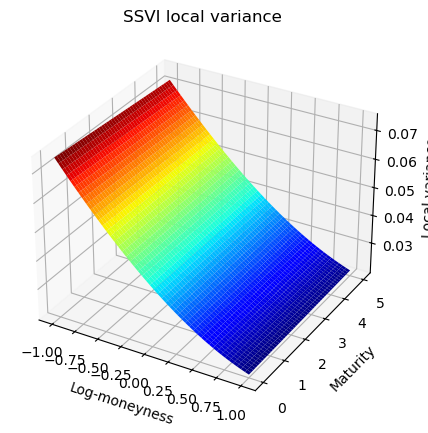

In [7]:
from mpl_toolkits.mplot3d import Axes3D  # required for 3D projection
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')  # ✅ Correct way to specify 3D

xxx, TTT = np.meshgrid(xx, TT)
localVarianceSSVI = np.array(localVarianceSSVI)
impliedVarianceSSVI = np.array(impliedVarianceSSVI)
ax.plot_surface(xxx, TTT, localVarianceSSVI, cmap=plt.cm.jet)
#ax.plot_surface(xxx, TTT, impliedVarianceSSVI, cmap=plt.cm.coolwarm)
ax.set_xlabel("Log-moneyness")
ax.set_ylabel("Maturity")
ax.set_zlabel("Local variance")
ax.set_title("SSVI local variance")
plt.show()

## Monte Carlo simulations

Run Monte Carlo simulation with the above local volatility for consistency check

In [8]:
def price_MC_LocalVol(s0, strike, T, params, nbSimul, nbSteps):
    deltaT = T / (1.*nbSteps)
    SS = np.linspace(s0, s0, nbSimul)
    time = np.linspace(deltaT, T, nbSteps)

    for t in time:
        sig = np.sqrt(SSVI_LocalVarg(np.log(SS), t, params))
        SS = SS*np.exp(-0.5*sig*sig*deltaT + np.sqrt(deltaT)*sig*random.normal(0., 1., nbSimul))
    price = np.mean(np.maximum(SS - strike, 0.))
    return price

### Numerical example

In [9]:
def Gdensity(x): ## Gaussian density
    return np.exp(-x*x/2.)/np.sqrt(2*np.pi)

#### Black Sholes Vega
def BlackScholesVegaCore(DF,F,X,T,v):
    vsqrt=v*np.sqrt(T)
    d1 = (np.log(F/X)+(vsqrt*vsqrt/2.))/vsqrt
    return F*Gdensity(d1)*np.sqrt(T)/DF

#### Black Sholes Function
def BlackScholesCore(CallPutFlag,DF,F,X,T,v):
    ## DF: discount factor
    ## F: Forward
    ## X: strike
    vsqrt=v*np.sqrt(T)
    d1 = (np.log(F/X)+(vsqrt*vsqrt/2.))/vsqrt
    d2 = d1-vsqrt
    if CallPutFlag:
        return DF*(F*norm.cdf(d1)-X*norm.cdf(d2))
    else:
        return DF*(X*norm.cdf(-d2)-F*norm.cdf(-d1))
    
##  Black-Scholes Pricing Function
def BlackScholes(CallPutFlag,S,X,T,r,d,v):
    ## r, d: continuous interest rate and dividend
    return BlackScholesCore(CallPutFlag,np.exp(-r*T),np.exp((r-d)*T)*S,X,T,v)

def BSimpliedvol(r,T,s0,K, price):
    ## Bisection algorithm when the Lee-Li algorithm breaks down
    def smileMin(vol, *args):
        K, s0, T, r, price = args
        return price - BlackScholes(True, s0, K, T, r, 0., vol)
    vMin, vMax = 0.000001, 2.
    return bisect(smileMin, vMin, vMax, args=(K, s0, T, r, price), xtol=1e-20, rtol=1e-15, full_output=False, disp=True)

In [10]:
sigma, gamma, rho = 0.2, 0.8, -0.7
s0, x, T = 1., 0., 1.
nbSimul, nbSteps = 10000, 100
xx = np.linspace(-0.5, 0.5, 10)
params = gamma, sigma, rho

print("Consistency check for no-arbitrage: ", (gamma - 0.25*(1.+np.abs(rho))>0.))

ssvivol = np.sqrt(SSVI(x, T, params)/T)
BSPrice = BlackScholesCore(True,1.,s0,s0*np.exp(x),T,ssvivol)
print("Black-Scholes implied vol: ", BSimpliedvol(0., T, s0, s0*np.exp(x), BSPrice))
print("SSVI implied vol: ", ssvivol)

price = price_MC_LocalVol(s0, s0*np.exp(x), T, params, nbSimul, nbSteps)
print("Implied vol from local volatility price by MC: ",  BSimpliedvol(0., T, s0, s0*np.exp(x), price))

Consistency check for no-arbitrage:  True
Black-Scholes implied vol:  0.19999999999999998
SSVI implied vol:  0.2
Implied vol from local volatility price by MC:  0.19942495050224757


# Example 2

We consider the following function
$$
\varphi(\theta)\equiv\frac{\eta}{\theta^\gamma},
$$
where $\gamma \in (0,1/2]$.

In [2]:
def phi(theta, params):
    gamma, eta, sigma, rho = params
    return eta / pow(theta, gamma)

def SSVI(x, t, params):
    gamma, eta, sigma, rho = params
    theta = sigma*sigma*t
    p = phi(theta, params)
    return 0.5*theta*(1.+rho*p*x+np.sqrt((p*x+rho)*(p*x+rho)+1.-rho*rho))

def SSVI1(x, t, params):
    ## First derivative with respect to x
    gamma, eta, sigma, rho = params
    theta = sigma*sigma*t
    p = phi(theta, params)
    return 0.5*theta*p*(p*x+rho*np.sqrt(p*p*x*x+2.*p*rho*x+1.)+rho)/np.sqrt(p*p*x*x+2.*p*rho*x+1.)

def SSVI2(x, t, params):
    ## Second derivative with respect to x
    gamma, eta, sigma, rho = params
    theta = sigma*sigma*t
    p = phi(theta, params)
    return 0.5*theta*p*p*(1.-rho*rho)/ ((p*p*x*x + 2.*p*rho*x + 1.)*np.sqrt(p*p*x*x+2.*p*rho*x+1.))
    
def SSVIt(x, t, params):
    ## First derivative with respect to t, by central difference
    eps = 0.0001
    return (SSVI(x,t+eps,params) - SSVI(x,t-eps,params))/(2.*eps)

def g(x, t, params):
    w = SSVI(x,t,params)
    w1 = SSVI1(x,t,params)
    w2 = SSVI2(x,t,params)
    return (1.-0.5*x*w1/w)*(1.-0.5*x*w1/w) - 0.25*w1*w1*(0.25 + 1./w) + 0.5*w2
    

def dminus(x, t, params):
    vsqrt = np.sqrt(SSVI(x,t,params))
    return -x/vsqrt - 0.5*vsqrt
    
def densitySSVI(x, t, params):
    dm = dminus(x,t,params)
    return g(x,t,params)*np.exp(-0.5*dm*dm)/np.sqrt(2.*np.pi*SSVI(x,t,params))

def SSVI_LocalVarg(x, t, params):
    ## Compute the equivalent SSVI local variance
    return SSVIt(x,t,params) / g(x,t,params)

## Numerical example

In [3]:
sigma, gamma, eta, rho = 0.2, 0.4, 0.2, -0.4
xx, TT = np.linspace(-1., 1., 20), np.linspace(0.1, 2., 20)

print("Consistency check to avoid static arbitrage: ", (gamma - 0.25*(1.+np.abs(rho))>0.))
params = gamma, eta, sigma, rho

localVarianceSSVI = [[SSVI_LocalVarg(x, t, params) for x in xx] for t in TT]

Consistency check to avoid static arbitrage:  True


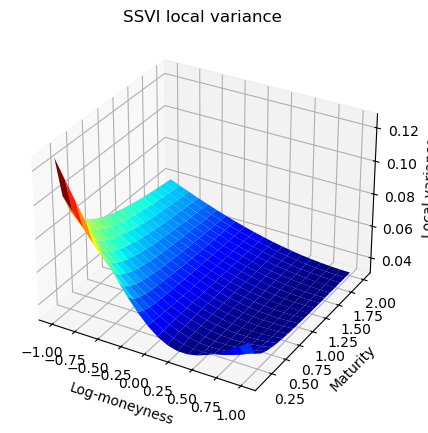

In [4]:
from mpl_toolkits.mplot3d import Axes3D  # required for 3D projection
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')  # ✅ Correct way to specify 3D

xxx, TTT = np.meshgrid(xx, TT)
localVarianceSSVI = np.array(localVarianceSSVI)
ax.plot_surface(xxx, TTT, localVarianceSSVI, cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0)
ax.set_xlabel("Log-moneyness")
ax.set_ylabel("Maturity")
ax.set_zlabel("Local variance")
ax.set_title("SSVI local variance")
plt.show()

In [16]:
import plotly.graph_objs as go
import numpy as np

# Assume xx, TT, localVarianceSSVI are already defined
xxx, TTT = np.meshgrid(xx, TT)
Z = np.array(localVarianceSSVI)

# Base surface
surface = go.Surface(
    x=xxx,
    y=TTT,
    z=Z,
    colorscale='Jet',
    showscale=False,
)

# Animation frames (rotate azimuth)
frames = []
for angle in range(0, 360, 5):
    eye = dict(x=np.cos(np.radians(angle)), y=np.sin(np.radians(angle)), z=0.5)
    frames.append(go.Frame(layout=dict(scene_camera=dict(eye=eye))))

# Layout with initial camera
layout = go.Layout(
    title='SSVI Local Variance',
    width=600,
    height=400,
    scene=dict(
        xaxis_title='Log-moneyness',
        yaxis_title='Maturity',
        zaxis_title='Local variance',
        camera=dict(eye=dict(x=1.25, y=1.25, z=0.5))
    ),
    updatemenus=[dict(
        type="buttons",
        showactive=False,
        buttons=[dict(label="▶️", method="animate", args=[None, {"frame": {"duration": 100, "redraw": True},
                                                                 "fromcurrent": True, "mode": "immediate"}])]
    )]
)

# Create figure
fig = go.Figure(data=[surface], layout=layout, frames=frames)
fig.show()
